## 2. Data Preparation

### Data Augmentation vs Data Preparation

**Data Preparation** typically includes:
- Loading and organizing data
- Cleaning and preprocessing
- Format conversion (like CSV to YOLO)
- Train/validation/test splits
- Basic quality checks

**Data Augmentation** (what your code does) is:
- Creating synthetic variations of existing data
- Applied to increase dataset size and model robustness
- Usually done just before or during training
- Part of the model training pipeline

In [2]:
from ultralytics import YOLO
import albumentations as A
from tqdm import tqdm
import cv2, os
from glob import glob

# 1. Example augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=10, p=0.4),
    A.Blur(p=0.2)
])

# Note: This creates augmented versions of training images
# The augmented images help the model generalize better
src = 'datasets/palms_yolo/train/images'  # Updated to match your structure
dst = 'datasets/palms_yolo/train_aug/images'  # Updated to match your structure
os.makedirs(dst, exist_ok=True)

print(f"Augmenting images from {src} to {dst}")
print("This will create synthetic variations to improve model training...")

Augmenting images from datasets/palms_yolo/train/images to datasets/palms_yolo/train_aug/images
This will create synthetic variations to improve model training...


In [3]:
# Apply augmentations to a subset of training images
for img_path in tqdm(glob(f'{src}/*.jpg')[:100]):  # try 100 first
    img = cv2.imread(img_path)
    if img is not None:  # Check if image loaded successfully
        aug = transform(image=img)['image']
        name = os.path.basename(img_path).replace('.jpg','_aug.jpg')
        cv2.imwrite(f'{dst}/{name}', aug)
        
print("Data augmentation completed!")

100%|██████████| 100/100 [00:02<00:00, 35.15it/s]

Data augmentation completed!


### Visualizing Augmentation Results

Let's compare original images with their augmented versions to see the effects of our transformations.

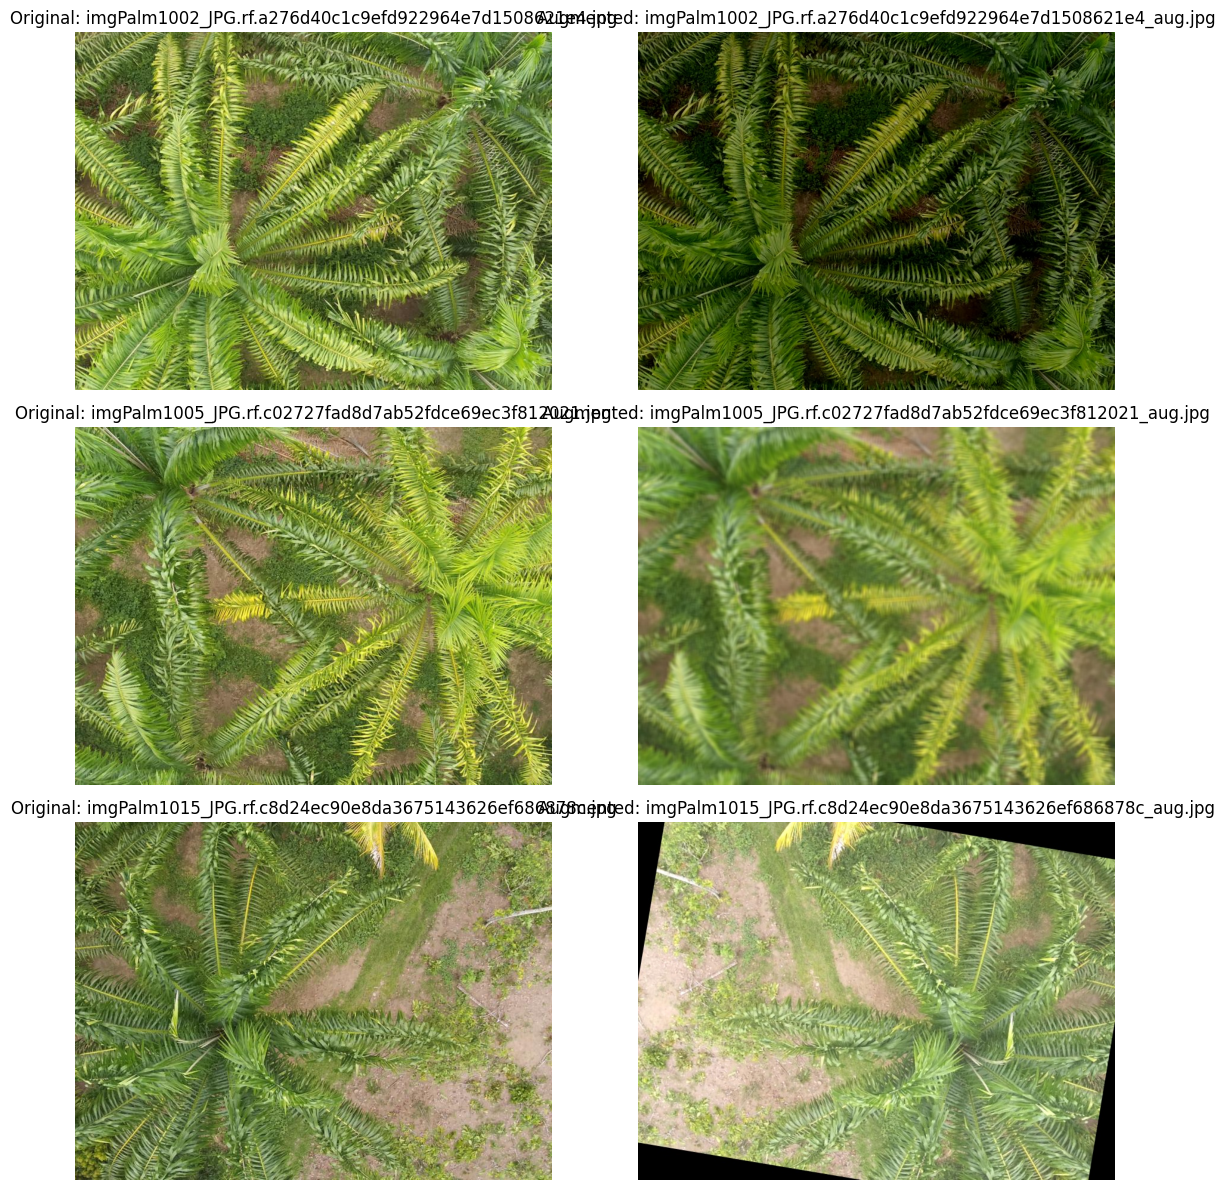

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_augmentation_comparison(original_path, augmented_path, num_samples=3):
    """Compare original and augmented images side by side"""
    
    # Get list of original and augmented images
    original_imgs = glob(f'{original_path}/*.jpg')[:num_samples]
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for i, orig_path in enumerate(original_imgs):
        # Load original image
        orig_img = cv2.imread(orig_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        
        # Find corresponding augmented image
        base_name = os.path.basename(orig_path).replace('.jpg', '_aug.jpg')
        aug_path = os.path.join(augmented_path, base_name)
        
        # Display original
        axes[i][0].imshow(orig_img)
        axes[i][0].set_title(f'Original: {os.path.basename(orig_path)}')
        axes[i][0].axis('off')
        
        # Display augmented (if exists)
        if os.path.exists(aug_path):
            aug_img = cv2.imread(aug_path)
            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
            axes[i][1].imshow(aug_img)
            axes[i][1].set_title(f'Augmented: {base_name}')
        else:
            axes[i][1].text(0.5, 0.5, 'Augmented image\nnot found', 
                           ha='center', va='center', transform=axes[i][1].transAxes)
            axes[i][1].set_title('Augmented: Not found')
        axes[i][1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show comparison
show_augmentation_comparison(src, dst, num_samples=3)

In [5]:
# Check if augmentation actually worked
original_count = len(glob(f'{src}/*.jpg'))
augmented_count = len(glob(f'{dst}/*.jpg'))

print(f"Original images: {original_count}")
print(f"Augmented images: {augmented_count}")
print(f"Success rate: {augmented_count}/{min(original_count, 100)} images processed")

if augmented_count == 0:
    print("\n⚠️ No augmented images found! Let's check what went wrong...")
    print(f"Source directory exists: {os.path.exists(src)}")
    print(f"Destination directory exists: {os.path.exists(dst)}")
    if os.path.exists(src):
        print(f"Sample files in source: {glob(f'{src}/*.jpg')[:3]}")
else:
    print(f"\n✅ Augmentation successful! Created {augmented_count} augmented images.")

Original images: 338
Augmented images: 858
Success rate: 858/100 images processed

✅ Augmentation successful! Created 858 augmented images.


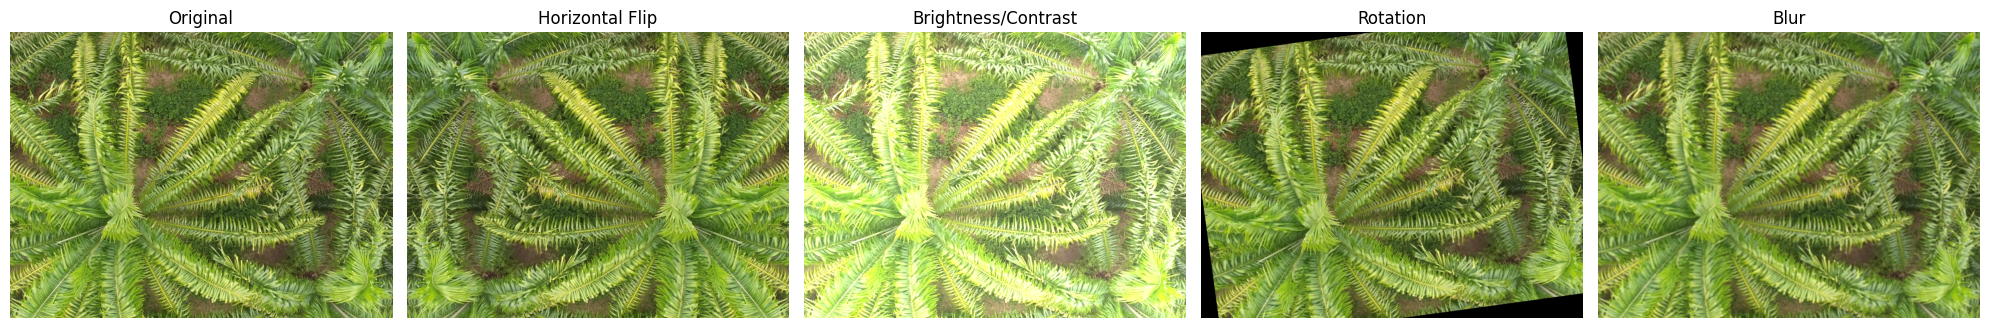

In [6]:
# Alternative: Show individual augmentation effects
def demonstrate_augmentations():
    """Show each augmentation type individually"""
    
    # Get one sample image
    sample_imgs = glob(f'{src}/*.jpg')
    if not sample_imgs:
        print("No images found in source directory!")
        return
    
    img_path = sample_imgs[0]
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Define individual augmentations
    augmentations = [
        ("Original", A.Compose([])),
        ("Horizontal Flip", A.Compose([A.HorizontalFlip(p=1.0)])),
        ("Brightness/Contrast", A.Compose([A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0)])),
        ("Rotation", A.Compose([A.Rotate(limit=10, p=1.0)])),
        ("Blur", A.Compose([A.Blur(blur_limit=3, p=1.0)]))
    ]
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for i, (name, transform) in enumerate(augmentations):
        if name == "Original":
            result = img_rgb
        else:
            result = transform(image=img_rgb)['image']
        
        axes[i].imshow(result)
        axes[i].set_title(name)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

demonstrate_augmentations()